In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch
from datetime import datetime
import pandas as pd
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoTokenizer
import numpy as np

from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, random_split, Subset



from pathlib import Path
from PIL import Image


## IMPORT

#### DATA

In [3]:
!unzip "/content/drive/MyDrive/tinyvlm/data/image-description-marketplace-data.zip" -d "/content/flip_data_vlm"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_1163.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_1166.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Promt_1243.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Quadro_Express_1438.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Quadro_Infix_1542.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Universal_RS050_5850.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Цветной_чехол_на_IPhone_14_Pro_Max_с_функцией_MagS_881.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Цветной_чехол_на_IPhone_14_Pro_Max_с_функцией_MagS_882.jpg  
  inflating: /

##### RELOAD DATA

In [4]:
class ImageTitleWithClipDataset(Dataset):
    def __init__(self, data):
        """
        data: list of dicts with keys:
          - image_path
          - text
          - image_embedding (CLIP)
          - text_embedding (CLIP)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        return (
            item["image_path"],         # PIL image will be loaded in training loop
            item["text"],               # text
            item["image_embedding"],    # CLIP image embedding (tensor)
            item["text_embedding"]      # CLIP text embedding (tensor)
        )

In [5]:
# Load the data from the .pt file
loaded_data = torch.load("/content/drive/MyDrive/tinyvlm/data/image_paths_with_clip_embeddings_large_ft.pt")

# Initialize the dataset with the loaded data
dataset = ImageTitleWithClipDataset(loaded_data)

##### RELOAD INDICIES

In [6]:
indices_dict = torch.load("/content/drive/MyDrive/tinyvlm/data/train_val_indices.pt")
train_indices = indices_dict["train_indices"]
val_indices = indices_dict["val_indices"]

# 3. Create Subsets using these indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

In [7]:

train_dataloader = DataLoader(train_dataset, batch_size=220, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=220, shuffle=False)

In [8]:
len(train_dataloader)

117

In [9]:
image, text, image_embedding, text_embedding = train_dataset[92]

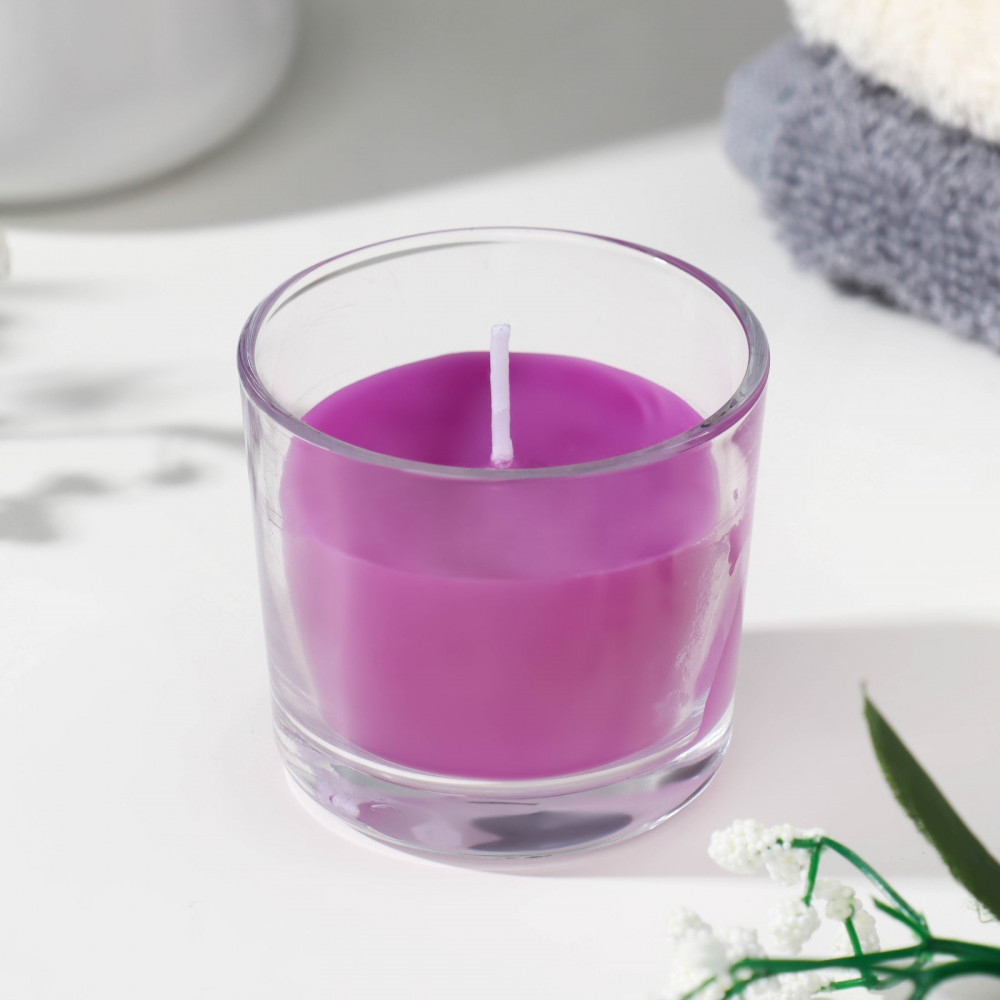

In [10]:
Image.open(image)

In [11]:
text

'Aromatic candle in a glass of "currant", currant'

## STUDENT MODEL BUILD

#### ARCHITECTURE

In [12]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `tken` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate whe

In [13]:
class DinoMiniLMDualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Text encoder (MiniLM)
        self.text_encoder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
        self.text_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

        # Image encoder (DINO)
        self.image_encoder = AutoModel.from_pretrained("facebook/dinov3-vits16-pretrain-lvd1689m")
        self.image_processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vits16-pretrain-lvd1689m")

        # Projection layers
        self.image_projection = nn.Linear(in_features=384, out_features=768)
        self.text_projection = nn.Linear(in_features=384, out_features=768)

    def forward(self, image, text):
        device = next(self.parameters()).device  # model's device (cpu/cuda)

        # --- Text encoding ---
        text_inputs = self.text_tokenizer(
            text, return_tensors="pt", padding=True, truncation=True
        ).to(device)
        text_outputs = self.text_encoder(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state.mean(dim=1)
        text_embeddings = self.text_projection(text_embeddings)

        # --- Image encoding ---
        image_processed = self.image_processor(images=image, return_tensors="pt").to(device)
        image_outputs = self.image_encoder(**image_processed)
        image_embeddings = self.image_projection(image_outputs.pooler_output)

        return text_embeddings, image_embeddings



In [ ]:
dino_minilm = DinoMiniLMDualEncoder().to('cuda')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [ ]:
sum(p.numel() for p in dino_minilm.parameters() if p.requires_grad == True)

In [ ]:
#### Freeze early layers

for parameter in dino_minilm.image_encoder.layer[0:9].parameters():
  parameter.requires_grad = False

for parameter in dino_minilm.text_encoder.encoder.layer[0:9].parameters():
  parameter.requires_grad = False

In [ ]:
sum(p.numel() for p in dino_minilm.parameters() if p.requires_grad == True)

In [ ]:
with torch.no_grad():

  #image = Image.open(train_dataset[42][0])


  x = dino_minilm( train_dataset[42][0],
                   train_dataset[42][1] )

#### TRAIN

##### LOSS

In [ ]:
import torch
import torch.nn.functional as F

def contrastive_distillation_loss_with_clip_filtering(
    student_image_embeddings: torch.Tensor,
    student_text_embeddings: torch.Tensor,
    teacher_clip_image_embeddings: torch.Tensor,
    teacher_clip_text_embeddings: torch.Tensor,
    temperature_student: float = 0.07,
    temperature_teacher: float = 0.07,
    similarity_threshold: float = 0.9
):
    """
    Contrastive Distillation Loss with Teacher CLIP Negative Filtering:
    - Aligns student image & text embeddings to fixed CLIP embeddings.
    - Uses InfoNCE-style contrastive loss.
    - Hard negative filtering based on teacher text embeddings.
    """

    # --- Normalize embeddings ---
    normalized_student_image_embeddings = F.normalize(student_image_embeddings, dim=-1)
    normalized_student_text_embeddings = F.normalize(student_text_embeddings, dim=-1)
    normalized_teacher_clip_image_embeddings = F.normalize(teacher_clip_image_embeddings, dim=-1)
    normalized_teacher_clip_text_embeddings = F.normalize(teacher_clip_text_embeddings, dim=-1)

    batch_size = normalized_student_image_embeddings.size(0)
    device = normalized_student_image_embeddings.device
    labels = torch.arange(batch_size, device=device)

    # --- 1. Student similarity matrices (student vs teacher) ---
    similarity_student_image_to_teacher_text = (
        normalized_student_image_embeddings @ normalized_teacher_clip_text_embeddings.T
    ) / temperature_student

    similarity_student_text_to_teacher_image = (
        normalized_student_text_embeddings @ normalized_teacher_clip_image_embeddings.T
    ) / temperature_student

    # --- 2. Teacher-based negative filtering (based on teacher text embeddings) ---
    teacher_text_cosine_similarity = normalized_teacher_clip_text_embeddings @ normalized_teacher_clip_text_embeddings.T
    teacher_negative_mask = teacher_text_cosine_similarity < similarity_threshold
    teacher_negative_mask.fill_diagonal_(True)
    teacher_negative_mask = teacher_negative_mask.to(device)

    similarity_student_image_to_teacher_text = similarity_student_image_to_teacher_text.masked_fill(
        ~teacher_negative_mask, float("-inf")
    )
    similarity_student_text_to_teacher_image = similarity_student_text_to_teacher_image.masked_fill(
        ~teacher_negative_mask, float("-inf")
    )

    # --- 3. Contrastive losses (InfoNCE) ---
    loss_image_to_text = F.cross_entropy(similarity_student_image_to_teacher_text, labels)
    loss_text_to_image = F.cross_entropy(similarity_student_text_to_teacher_image, labels)
    contrastive_distillation_loss = (loss_image_to_text + loss_text_to_image) / 2

    # --- 4. Stats ---
    total_negatives = batch_size * (batch_size - 1)
    kept_mask = teacher_negative_mask.clone()
    kept_mask.fill_diagonal_(False)
    negatives_kept = kept_mask.sum().item()
    negatives_filtered = total_negatives - negatives_kept

    stats = {
        "contrastive_distillation_loss": float(contrastive_distillation_loss.item()),
        "negatives_kept": negatives_kept,
        "negatives_filtered": negatives_filtered,
        "negatives_total": total_negatives,
    }

    return contrastive_distillation_loss, stats





##### LOOP

In [ ]:
optimizer = torch.optim.Adam(dino_minilm.parameters(), lr=1e-5)

In [ ]:

val_losses = []
val_distill_losses = []

for epoch in range(50):
  dino_minilm.train()

  for batch_idx, (image_paths, texts, clip_image_embeddings, clip_text_embeddings) in enumerate(train_dataloader):

    clip_text_embeddings, clip_image_embeddings = clip_text_embeddings.to('cuda'), clip_image_embeddings.to('cuda')

    pil_images = [Image.open(p).convert("RGB") for p in image_paths]

    optimizer.zero_grad()

    minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

    cf_distill_loss, stats = contrastive_distillation_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                                               student_text_embeddings = minilm_embeddings,
                                                                               teacher_clip_image_embeddings = clip_image_embeddings,
                                                                               teacher_clip_text_embeddings = clip_text_embeddings)

    cf_distill_loss.backward()

    optimizer.step()

    print(f'{datetime.now()} /// Epoch {epoch+1} {batch_idx+1}/{len(train_dataloader)} proocessed, STATS : {stats}')



  for image_paths, texts, clip_image_embeddings, clip_text_embeddings in val_dataloader:

    val_epoch_losses = []

    with torch.no_grad():
      pil_images = [Image.open(p).convert("RGB") for p in image_paths]

      clip_text_embeddings, clip_image_embeddings = clip_text_embeddings.to('cuda'), clip_image_embeddings.to('cuda')

      minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

      val_cf_distill_loss, stats = contrastive_distillation_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                                                     student_text_embeddings = minilm_embeddings,
                                                                                     teacher_clip_image_embeddings = clip_image_embeddings,
                                                                                     teacher_clip_text_embeddings = clip_text_embeddings)

      val_epoch_losses.append(val_cf_distill_loss.item())


  val_losses.append(np.mean(val_epoch_losses))

  print(f'{datetime.now()} /// Epoch {epoch+1} Val Loss : {np.mean(val_epoch_losses)}')
















2025-10-11 08:48:22.959352 /// Epoch 1 1/117 proocessed, STATS : {'contrastive_distillation_loss': 5.521710395812988, 'negatives_kept': 48164, 'negatives_filtered': 16, 'negatives_total': 48180}
2025-10-11 08:48:28.611208 /// Epoch 1 2/117 proocessed, STATS : {'contrastive_distillation_loss': 5.496953010559082, 'negatives_kept': 48158, 'negatives_filtered': 22, 'negatives_total': 48180}
2025-10-11 08:48:34.215027 /// Epoch 1 3/117 proocessed, STATS : {'contrastive_distillation_loss': 5.481057167053223, 'negatives_kept': 48162, 'negatives_filtered': 18, 'negatives_total': 48180}
2025-10-11 08:48:40.548281 /// Epoch 1 4/117 proocessed, STATS : {'contrastive_distillation_loss': 5.456070899963379, 'negatives_kept': 48166, 'negatives_filtered': 14, 'negatives_total': 48180}
2025-10-11 08:48:46.023289 /// Epoch 1 5/117 proocessed, STATS : {'contrastive_distillation_loss': 5.410867691040039, 'negatives_kept': 48170, 'negatives_filtered': 10, 'negatives_total': 48180}
2025-10-11 08:48:51.59115

KeyboardInterrupt: 

<Axes: >

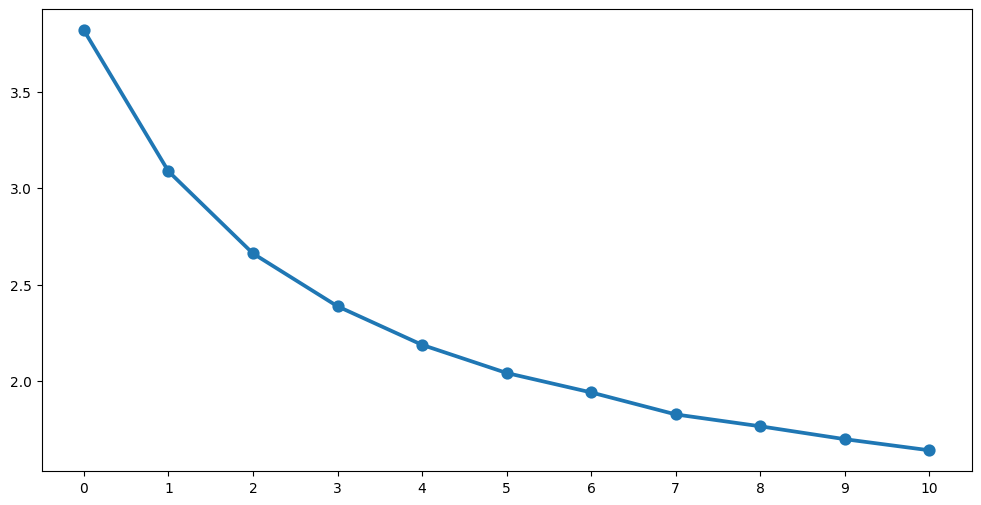

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))


sns.pointplot(data = val_losses)

In [ ]:
#### RELOAD WEIGHTS

dino_minilm_stage1_state_dict = torch.load("/content/drive/MyDrive/tinyvlm/models/dino_minilm_stage2v2.pth")
dino_minilm.load_state_dict(dino_minilm_stage1_state_dict)

In [ ]:
#### Freeze early layers

for parameter in dino_minilm.image_encoder.layer[0:9].parameters():
  parameter.requires_grad = False

for parameter in dino_minilm.text_encoder.encoder.layer[0:9].parameters():
  parameter.requires_grad = False

In [ ]:
#### CONTINUATION



val_losses = []
val_distill_losses = []

for epoch in range(50):
  dino_minilm.train()

  for batch_idx, (image_paths, texts, clip_image_embeddings, clip_text_embeddings) in enumerate(train_dataloader):

    clip_text_embeddings, clip_image_embeddings = clip_text_embeddings.to('cuda'), clip_image_embeddings.to('cuda')

    pil_images = [Image.open(p).convert("RGB") for p in image_paths]

    optimizer.zero_grad()

    minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

    cf_distill_loss, stats = contrastive_distillation_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                                               student_text_embeddings = minilm_embeddings,
                                                                               teacher_clip_image_embeddings = clip_image_embeddings,
                                                                               teacher_clip_text_embeddings = clip_text_embeddings)

    cf_distill_loss.backward()

    optimizer.step()

    print(f'{datetime.now()} /// Epoch {epoch+1} {batch_idx+1}/{len(train_dataloader)} proocessed, STATS : {stats}')



  for image_paths, texts, clip_image_embeddings, clip_text_embeddings in val_dataloader:

    val_epoch_losses = []

    with torch.no_grad():
      pil_images = [Image.open(p).convert("RGB") for p in image_paths]

      clip_text_embeddings, clip_image_embeddings = clip_text_embeddings.to('cuda'), clip_image_embeddings.to('cuda')

      minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

      val_cf_distill_loss, stats = contrastive_distillation_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                                                     student_text_embeddings = minilm_embeddings,
                                                                                     teacher_clip_image_embeddings = clip_image_embeddings,
                                                                                     teacher_clip_text_embeddings = clip_text_embeddings)

      val_epoch_losses.append(val_cf_distill_loss.item())


  val_losses.append(np.mean(val_epoch_losses))

  print(f'{datetime.now()} /// Epoch {epoch+1} Val Loss : {np.mean(val_epoch_losses)}')

In [ ]:
torch.save( dino_minilm.state_dict(), "/content/drive/MyDrive/tinyvlm/models/dino_minilm_stage2v2.pth" )